In [1]:
import torch.nn.functional as F
import torch
import numpy as np
from pathlib import Path
import plotly.graph_objs as go
import matplotlib.pyplot as plt


from initialization import NeuralSurfaceReconstruction

In [2]:
nsr = NeuralSurfaceReconstruction(
    data=Path("../data/calculator"),
    device=torch.device("cuda:0"),
    image_scale=1/32,
)
len(nsr.images)

703

In [3]:
optimizer = torch.optim.Adam(nsr.model.parameters(), lr=0.01, eps=10e-12)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
#                                                        patience=10, factor=0.1)

In [4]:
def get_batched_viewpoint(total: int, step: int, batch_size: int, epochs: int):
    return np.tile(
        np.arange(
            0, total, step
        )[:(int((total/step)//batch_size)*batch_size)].reshape((-1, batch_size))[np.newaxis],
        (epochs, 1, 1)
    )

In [5]:
epochs = get_batched_viewpoint(total=len(nsr.images),
                               step=10,
                               batch_size=6, 
                               epochs=1)
epochs

array([[[  0,  10,  20,  30,  40,  50],
        [ 60,  70,  80,  90, 100, 110],
        [120, 130, 140, 150, 160, 170],
        [180, 190, 200, 210, 220, 230],
        [240, 250, 260, 270, 280, 290],
        [300, 310, 320, 330, 340, 350],
        [360, 370, 380, 390, 400, 410],
        [420, 430, 440, 450, 460, 470],
        [480, 490, 500, 510, 520, 530],
        [540, 550, 560, 570, 580, 590],
        [600, 610, 620, 630, 640, 650]]])

In [6]:
N_query_points = 150
EPOCHS = 3
IMAGE_EPOCHS = 100

for epoch in range(EPOCHS):
    match epoch:
        case 0:
            batches = get_batched_viewpoint(total=len(nsr.images),
                                            step=20,
                                            batch_size=24, 
                                            epochs=1)[0]
        case 1:
            batches = get_batched_viewpoint(total=len(nsr.images),
                                            step=10,
                                            batch_size=12, 
                                            epochs=1)[0]
            
            nsr.double_grid()
            nsr.increment_sharpness()
            N_query_points *= 2
        case 2:
            batches = get_batched_viewpoint(total=len(nsr.images),
                                            step=10,
                                            batch_size=6, 
                                            epochs=1)[0]
            
            nsr.double_grid()
            nsr.increment_sharpness()
            N_query_points *= 2

    print("EPOCH:", epoch, "SHARPNESS:", nsr.model.sharpness, "FG VOXEL SIZE:", nsr.fg_V.voxel_size)

    for batch, viewpoints in enumerate(batches):
        print("BATCH:", batch)

        btp, bst, bv = [], [], []
        for viewpoint in viewpoints:
            print("::: PREPROCESSING:", viewpoint)
            
            tp, st, v = nsr.query_data(viewpoint, N_query_points=N_query_points)
            
            btp.append(tp[torch.newaxis])
            bst.append(st[torch.newaxis])
            bv.append(v[torch.newaxis])
        
        btp = torch.concat(tuple(btp))
        bst = torch.concat(tuple(bst))
        bv = torch.concat(tuple(bv))

        for image_epoch in range(0, IMAGE_EPOCHS):
            print("IMAGE EPOCH:", image_epoch, end="\t")

            optimizer.zero_grad()

            loss, _ = nsr.model(btp, bst, bv)
            loss.backward()
            optimizer.step()

            # nsr.update_sharpness()
        
            print("LOSS: ", loss.item())


EPOCH: 0 SHARPNESS: 1 FG VOXEL SIZE: 16
BATCH: 0
::: PREPROCESSING: 0
::: PREPROCESSING: 20
::: PREPROCESSING: 40
::: PREPROCESSING: 60
::: PREPROCESSING: 80
::: PREPROCESSING: 100
::: PREPROCESSING: 120
::: PREPROCESSING: 140
::: PREPROCESSING: 160
::: PREPROCESSING: 180
::: PREPROCESSING: 200
::: PREPROCESSING: 220
::: PREPROCESSING: 240
::: PREPROCESSING: 260
::: PREPROCESSING: 280
::: PREPROCESSING: 300
::: PREPROCESSING: 320
::: PREPROCESSING: 340
::: PREPROCESSING: 360
::: PREPROCESSING: 380
::: PREPROCESSING: 400
::: PREPROCESSING: 420
::: PREPROCESSING: 440
::: PREPROCESSING: 460
IMAGE EPOCH: 0 LOSS:  151501.828125
IMAGE EPOCH: 1 LOSS:  106422.9765625
IMAGE EPOCH: 2 LOSS:  80494.9296875
IMAGE EPOCH: 3 LOSS:  70070.7578125
IMAGE EPOCH: 4 LOSS:  69732.9765625
IMAGE EPOCH: 5 LOSS:  70700.59375
IMAGE EPOCH: 6 LOSS:  68067.7734375
IMAGE EPOCH: 7 LOSS:  62183.8203125
IMAGE EPOCH: 8 LOSS:  55354.03515625
IMAGE EPOCH: 9 LOSS:  49557.3515625
IMAGE EPOCH: 10 LOSS:  45523.8359375
IMAGE EP

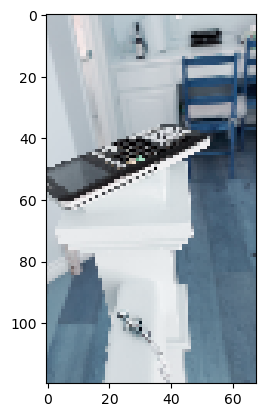

In [30]:
tp, st, v = nsr.query_data(200, N_query_points=600)
_, rendering = nsr.model(tp[torch.newaxis], st[torch.newaxis], v[torch.newaxis])

plt.imshow(tp.detach().cpu().reshape((1080//16+1, 1920//16, 3)).permute(1,0,2).float().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


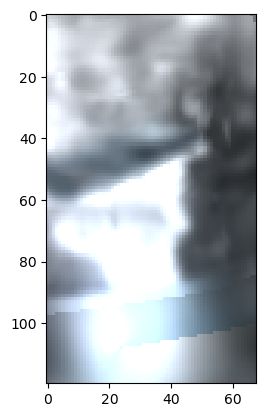

In [32]:
img = rendering.cpu().reshape((1080//16+1, 1920//16, 3)).permute(1,0,2)

plt.imshow(img.detach().numpy())

In [35]:
torch.save(nsr.model.state_dict(), "./nsr000.pt")
torch.save(optimizer.state_dict(), "./nsr000o.pt")

In [31]:
nsr.model.s.fg_sdf.shape, nsr.model.s.bg_sdf.shape

(torch.Size([1, 1, 32, 32, 32]), torch.Size([1, 1, 32, 32, 32]))

In [5]:
# torch.autograd.set_detect_anomaly(True)
# torch.cuda.empty_cache()

EPOCHS = 1
IMAGE_EPOCHS = 100
BATCH_SIZE = 24

N_query_points = 150

for epoch in range(0, EPOCHS):

    for viewpoint in range(0, 1, BATCH_SIZE): #len(nsr.images)//10):
        
        print(f"::: VIEWPOINT: {viewpoint}")

        # for g in optimizer.param_groups:
        #             g["lr"] = 0.01

        # if 35 > viewpoint >= 30:
        #     nsr.grid_doubling()
        #     N_query_points *= 2

        # HxWx3=Nx3, NxTx3, 2xN
        btp, bst, bv = [], [], []
        for b in range(BATCH_SIZE):
            tp, st, v = nsr.query_data(viewpoint+b, N_query_points=N_query_points,
                                    t_size=abs(nsr.fg_V.step_size/2))
            
            # print(tp.shape)
            # print(st.shape)
            # print(v.shape)
            print("BATCH:", viewpoint+b)
            btp.append(tp[torch.newaxis])
            bst.append(st[torch.newaxis])
            bv.append(v[torch.newaxis])
        
        # btp = tp[torch.newaxis]
        # bst = st[torch.newaxis]
        # bv = v[torch.newaxis]
        # btp = torch.tensor(btp)
        # bst = torch.tensor(bst)
        # bv = torch.tensor(bv)
        btp = torch.concat(tuple(btp))
        bst = torch.concat(tuple(bst))
        bv = torch.concat(tuple(bv))

        for image_epoch in range(0, IMAGE_EPOCHS):
            print(f"IMAGE EPOCH: {image_epoch}")

            total_loss = 0.0

           
            # if image_epoch == 50:
            #     for g in optimizer.param_groups:
            #         g["lr"] = 0.001


            # MINIBATCH_SIZE = st.shape[0]//4
            # for i in range(0, st.shape[0], MINIBATCH_SIZE):
            optimizer.zero_grad()

            # output = nsr.model(st, v)
            # output = output.cpu() #.detach()

            # # print(output.requires_grad)

            # # photo_loss = torch.linalg.norm(tp[i:i+MINIBATCH_SIZE]-output, dim=1).sum()
            # # photo_loss.backward()

            # loss = photo_loss(tp, output)
            # loss.backward()

            loss, _ = nsr.model(btp, bst, bv)
            loss.backward()

            total_loss += loss.item()

            optimizer.step()
        
        
            # scheduler.step(total_loss)

            # nsr.update_sharpness()

        
            print(total_loss)
            # print(scheduler.get_last_lr())



::: VIEWPOINT: 0
BATCH: 0
BATCH: 1
BATCH: 2
BATCH: 3
BATCH: 4
BATCH: 5
BATCH: 6
BATCH: 7
BATCH: 8
BATCH: 9
BATCH: 10
BATCH: 11
BATCH: 12
BATCH: 13
BATCH: 14
BATCH: 15
BATCH: 16
BATCH: 17
BATCH: 18
BATCH: 19
BATCH: 20
BATCH: 21
BATCH: 22
BATCH: 23
IMAGE EPOCH: 0
139263.515625
IMAGE EPOCH: 1
104403.8515625
IMAGE EPOCH: 2
82899.8828125
IMAGE EPOCH: 3
72281.3515625
IMAGE EPOCH: 4
70233.8125
IMAGE EPOCH: 5
70079.015625
IMAGE EPOCH: 6
66544.8203125
IMAGE EPOCH: 7
59744.27734375
IMAGE EPOCH: 8
51911.3359375
IMAGE EPOCH: 9
45096.265625
IMAGE EPOCH: 10
40257.33984375
IMAGE EPOCH: 11
37128.078125
IMAGE EPOCH: 12
34865.76171875
IMAGE EPOCH: 13
32705.115234375
IMAGE EPOCH: 14
30330.291015625
IMAGE EPOCH: 15
27862.94140625
IMAGE EPOCH: 16
25691.46875
IMAGE EPOCH: 17
24167.697265625
IMAGE EPOCH: 18
23250.466796875
IMAGE EPOCH: 19
22432.27734375
IMAGE EPOCH: 20
21211.880859375
IMAGE EPOCH: 21
19648.47265625
IMAGE EPOCH: 22
18220.962890625
IMAGE EPOCH: 23
17288.98046875
IMAGE EPOCH: 24
16790.03515625


In [32]:
for g in optimizer.param_groups:
    print(g["lr"])

0.01


In [4]:
from torchview import draw_graph

# torchviz.make_dot(output, nsr.model.named_parameters())

model_graph = draw_graph(nsr.model, input_size=[st.shape, v.shape], depth=1, device="meta")
model_graph.visual_graph

NameError: name 'st' is not defined

In [9]:
print(type(model_graph.visual_graph))

<class 'graphviz.graphs.Digraph'>


In [16]:
model_graph.visual_graph.render("./nsr_graph.png")


(process:24424): Pango-WARNING **: 09:38:03.421: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'nsr_graph.png.pdf'

In [10]:
model_graph = draw_graph(nsr.model.s, input_size=(st.shape[0], st.shape[2]), depth=2, device="meta")
model_graph.visual_graph.render("./S_graph.png")


(process:27400): Pango-WARNING **: 09:48:44.052: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'S_graph.png.pdf'

In [11]:
model_graph = draw_graph(nsr.model.lo, input_size=[(st.shape[0], st.shape[2]), v.shape], depth=2, device="meta")
model_graph.visual_graph.render("./Lo_graph.png")


(process:24908): Pango-WARNING **: 09:48:44.862: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'Lo_graph.png.pdf'

In [20]:
# _, st, _ = nsr.query_data(50,
#                           N_query_points=150, t_size=abs(nsr.fg_V.step_size/2),  # 0.15, #
#                           _pixel_grid_width_step=25.0,
#                           _pixel_grid_height_step=25.0,
#                           _scale = 1)
_, st, _ = nsr.query_data(0, N_query_points=300, t_size=abs(nsr.fg_V.step_size/2),
                          _pixel_grid_width_step=10.0,
                          _pixel_grid_height_step=10.0,)


In [21]:
st.shape, nsr.fg_V.step_size/2

(torch.Size([336, 300, 3]), tensor(-0.0484, device='cuda:0'))

In [22]:
nsr.model.s.fg.center, nsr.model.s.fg.scale, nsr.fg_V.step_size, nsr.model.s.fg_sdf.shape, nsr.model.s.bg_sdf.shape

(tensor([-1.7500,  1.5000,  0.5000], device='cuda:0'),
 tensor([1.5000, 1.5000, 1.5000], device='cuda:0'),
 tensor(-0.0968, device='cuda:0'),
 torch.Size([1, 1, 32, 32, 32]),
 torch.Size([1, 1, 32, 32, 32]))

In [ ]:
go.Figure(data=[
    go.Scatter3d(
        x=nsr.fg_V.grid_pos[0].flatten().cpu().detach().numpy(),
        y=nsr.fg_V.grid_pos[1].flatten().cpu().detach().numpy(),
        z=nsr.fg_V.grid_pos[2].flatten().cpu().detach().numpy(),
        mode='markers',
        marker={
            'size': 10,
            "color": nsr.fg_V.sdf.flatten().cpu().detach().numpy(),
            'opacity': 0.3,
            "cmax": 1.0,
            "cmin": -1.0,
            "colorbar": {
                "thickness": 10,
            }
        }
    ),
    # go.Scatter3d(
    #     x=nsr.bg_V.grid_pos[0].flatten().cpu().detach().numpy(),
    #     y=nsr.bg_V.grid_pos[1].flatten().cpu().detach().numpy(),
    #     z=nsr.bg_V.grid_pos[2].flatten().cpu().detach().numpy(),
    #     mode='markers',
    #     marker={
    #         'size': 10,
    #         "color": nsr.bg_V.sdf.flatten().cpu().detach().numpy(),
    #         'opacity': 0.2,
    #         "cmax": 1.0,
    #         "cmin": -1.0,
    #         # "colorbar": {
    #         #     "thickness": 10,
    #         # }
    #     }
    # ),
    # go.Scatter3d(
    #     x=new_fg.grid_pos[0].flatten().cpu().detach().numpy(),
    #     y=new_fg.grid_pos[1].flatten().cpu().detach().numpy(),
    #     z=new_fg.grid_pos[2].flatten().cpu().detach().numpy(),
    #     mode='markers',
    #     marker={
    #         'size': 10,
    #         "color": new_fg.sdf.flatten().cpu().detach().numpy(),
    #         'opacity': 0.3,
    #         "cmax": 1.0,
    #         "cmin": -1.0,
    #         "colorbar": {
    #             "thickness": 10,
    #         }
    #     }
    # ),
    # go.Scatter3d(
    #     x=new_bg.grid_pos[0].flatten().cpu().detach().numpy(),
    #     y=new_bg.grid_pos[1].flatten().cpu().detach().numpy(),
    #     z=new_bg.grid_pos[2].flatten().cpu().detach().numpy(),
    #     mode='markers',
    #     marker={
    #         'size': 10,
    #         "color": new_bg.sdf.flatten().cpu().detach().numpy(),
    #         'opacity': 0.2,
    #         "cmax": 1.0,
    #         "cmin": -1.0,
    #         # "colorbar": {
    #         #     "thickness": 10,
    #         # }
    #     }
    # ),
    # go.Scatter3d(
    #     x=st[:,:,0].flatten().cpu().numpy(),
    #     y=st[:,:,1].flatten().cpu().numpy(),
    #     z=st[:,:,2].flatten().cpu().numpy(),
    #     mode='markers',
    #     marker={
    #         'size': 3,
    #         'opacity': 1.0,
    #     }
    # ),
], layout=go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    scene=dict(
        aspectmode="cube",
        xaxis=dict(range=[-30, 30]),  # Set x-axis range
        yaxis=dict(range=[-30, 30]),  # Set y-axis range
        zaxis=dict(range=[-30, 30])   # Set z-axis range
    ),
    scene_camera= dict(
        eye=dict(x=0.0, y=0.0, z=0.1)
    )
))